# Convolutional Neural Networks

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

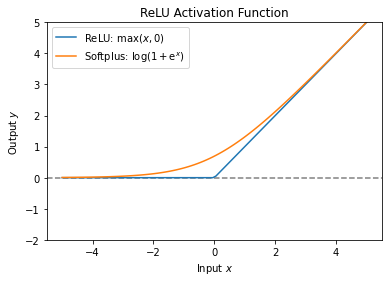

In [58]:
def relu(x):
    """Rectifier Linear Unit activation function"""
    if x > 0.0: return x
    else: return 0

def softplus(x):
    return np.log(1 + np.exp(x))
    
vrelu = np.vectorize(relu, otypes="f")
x = np.linspace(-5, 5, 100)
y = vrelu(x)
y2 = softplus(x)
plt.ylim(-2, 5)
plt.axhline(0, color="grey", linestyle="dashed", label="_nolegend_")
plt.plot(x, y, "-")
plt.plot(x, y2)
plt.legend(["ReLU: $\max(x, 0)$", "Softplus: $\log(1 + \mathrm{e}^{x})$"])
plt.title("ReLU Activation Function")
plt.xlabel("Input $x$")
plt.ylabel("Output $y$")
plt.savefig("figures/relu.png")
plt.show()

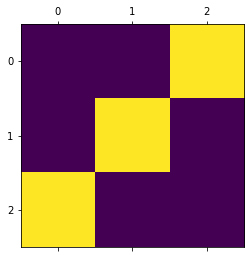

In [142]:
# kernel

k = -1*np.zeros((3,3))
k[2,0] = 1
k[1,1] = 1
k[0,2] = 1
plt.matshow(k, origin="upper")


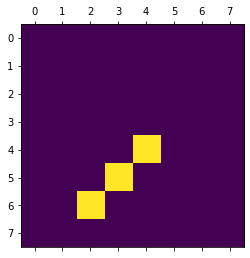

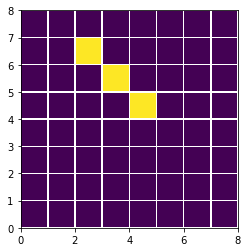

In [132]:
x = np.zeros((8,8))
x[6,2] = 1
x[5,3] = 1
x[4,4] = 1
plt.matshow(x, origin="upper")
#plt.grid(which='minor')
plt.show()
fig = plt.figure()
ax = fig.add_subplot()
plt.pcolormesh(x, edgecolors='w', linewidth=0.5)
ax.set_aspect('equal')

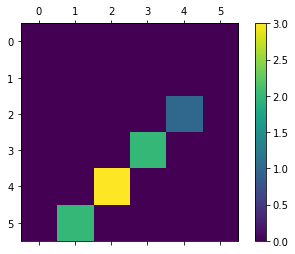

In [139]:
c = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rfield = x[i:(i+3),j:(j+3)]
        ii = rfield * k
        z = np.sum(ii)
        c[i,j] = relu(z)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(c, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

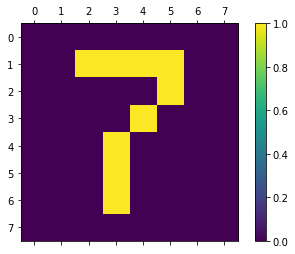

In [140]:
num = np.loadtxt("7_8x8.txt")
#num = num*2 - 1
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(num, interpolation='nearest', origin="upper")
fig.colorbar(cax)

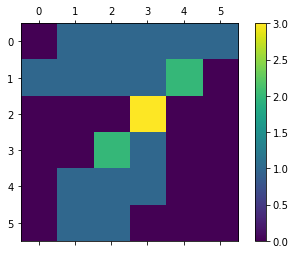

In [143]:
c = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rfield = num[i:(i+3),j:(j+3)]
        ii = rfield * k
        z = np.sum(ii)
        c[i,j] = relu(z)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(c, interpolation='nearest', origin="upper")
fig.colorbar(cax)
plt.show()

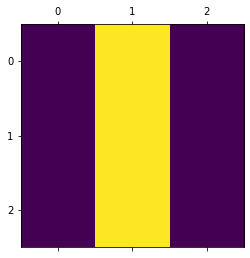

In [147]:
k1 = k
k2 = np.zeros((3,3))
k2[1,0] = 1
k2[1,1] = 1
k2[1,2] = 1

k3 = np.zeros((3,3))
k3[0,1] = 1
k3[1,1] = 1
k3[2,1] = 1


plt.matshow(k3, origin="upper")


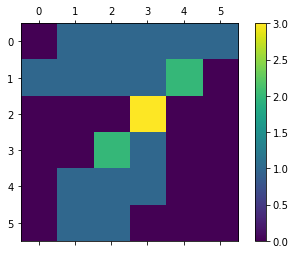

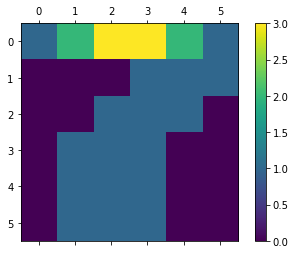

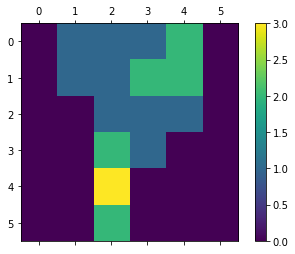

In [148]:

kernels = [k1, k2, k3]
clayers = [np.zeros((6,6)) for x in kernels]

for k, c in zip(kernels, clayers):
    for i in range(6):
        for j in range(6):
            rfield = num[i:(i+3),j:(j+3)]
            ii = rfield * k
            z = np.sum(ii)
            c[i,j] = relu(z)
            
for c in clayers:
    fig = plt.figure()
    ax = fig.add_subplot()
    cax = ax.matshow(c, interpolation='nearest', origin="upper")
    fig.colorbar(cax)
plt.show()

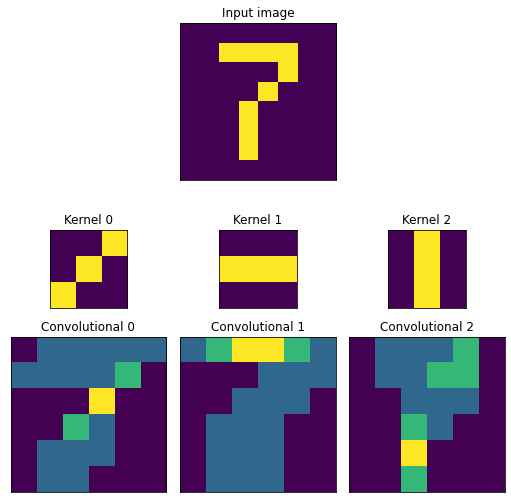

In [205]:
import matplotlib.gridspec as gs

fig = plt.figure(constrained_layout=True, figsize=(7,7))

spec = gs.GridSpec(3, 3, width_ratios=(1,1,1), height_ratios=(8,3,6), figure=fig)

ax = fig.add_subplot(spec[0, 1])
ax.matshow(num, interpolation='nearest', origin="upper")
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_title("Input image")

for i, k in enumerate(kernels):
    ax = fig.add_subplot(spec[1, i])
    ax.matshow(k, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Kernel %d" % i)
    #fig.colorbar(cax)

for i, c in enumerate(clayers):
    ax = fig.add_subplot(spec[2, i])
    ax.matshow(c, interpolation='nearest', origin="upper")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_title("Convolutional %d" % i)

plt.savefig("figures/multiple_conv_layers.png")

In [ ]:
"